In [116]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.tools.grids import domain
from ppfft.tools.new_fft import new_fft, adj_new_fft, new_fft2, new_ifft
from ppfft.tools.pad import pad, adj_pad
from ppfft.tools.frac_fft import frac_fft, adj_frac_fft

# Forward PPFFT

We first define the Pseudo-Polar FFT for the basically horizontal lines:

In [89]:
def ppfft_horizontal(im):
    n = im.shape[0]
    m = 2 * n + 1
    res = np.zeros(shape=(n + 1, 2 * n + 1), dtype=complex)  # l, k
    fft_col = new_fft(pad(im, new_shape=(n, m)), axis=-1)

    for k, col in zip(domain(m), fft_col.T):
        res[:, k + n] = frac_fft(col, beta=-2 * k / (n * (2 * n + 1)), m=n + 1)
    return res

Here we define the coordinates of the horizontal lines. In the paper, they are given by (when $n$ is even):
$$
\left\{ \left(- \frac{2l}{n}k, k \right) \mid l \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket, \, k \in \llbracket -n, n \rrbracket \right\}
$$

In [90]:
def horizontal_lines(n: int):
    """
    Computes the positions of the basically horizontal lines of the pseudo-polar grid.

    ## Parameters
    n : int
        Size of the image whose PPFFT we want to compute.

    ## Returns
    coords : np.ndarray
        Array of shape (n+1, 2*n+1, 2). coords[..., 0] gives the x coordinates.

    ## See Also
    vertical_lines : Return the positions of the basically vertical lines of the pseudo-polar grid.
    """
    m = 2 * n + 1
    coords = np.empty(shape=(n + 1, m, 2))

    for i_l, l in enumerate(domain(n + 1)):
        for i_k, k in enumerate(domain(2 * n + 1)):
            coords[i_l, i_k, 0] = -2 * l * k / n
            coords[i_l, i_k, 1] = k

    return coords


In [91]:
n = 10
coords = horizontal_lines(n)

In [92]:
hori_x_coords = coords[..., 0]
hori_y_coords = coords[..., 1]

[]

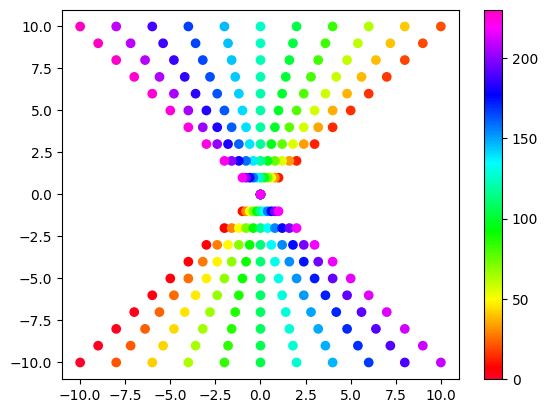

In [93]:
plt.scatter(hori_x_coords.flatten(), hori_y_coords.flatten(),
            c=np.arange(hori_x_coords.size), cmap='gist_rainbow')
plt.colorbar()
plt.plot()

In [94]:
a = np.random.rand(n, n)
hori_ppfft = ppfft_horizontal(a)

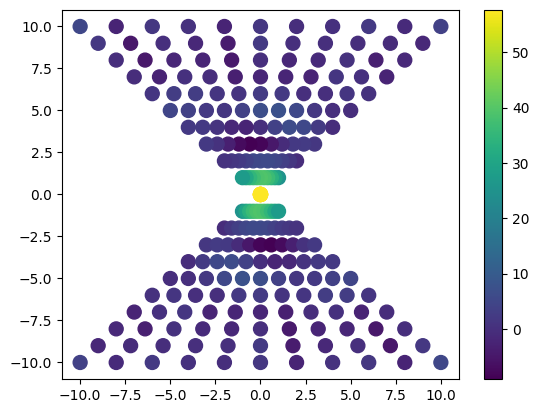

In [95]:
plt.scatter(hori_x_coords.flatten(), hori_y_coords.flatten(),
            c=hori_ppfft.real.flatten(), s=100)
plt.colorbar()
plt.show()

In order to check that the computed values are correct, we directly compute the Discrete Time Fourier Transform on the pseudo-polar grid:

In [96]:
def slow_DTFT(a, omega_x, omega_y, m):
    n, _ = a.shape
    q_n, r_n = divmod(n, 2)
    u = np.arange(-q_n, q_n + r_n)
    v = np.arange(-q_n, q_n + r_n)
    return np.einsum("uv,u,v->", a, np.exp(-2j * np.pi * omega_x * u / m), np.exp(-2j * np.pi * omega_y * v / m))

In [97]:
true_hori_ppfft = np.empty(shape=(n + 1, 2 * n + 1), dtype=complex)

for l in range(n + 1):
    for k in range(2 * n + 1):
        true_hori_ppfft[l, k] = slow_DTFT(a, hori_x_coords[l, k],
                                          hori_y_coords[l, k], 2 * n + 1)

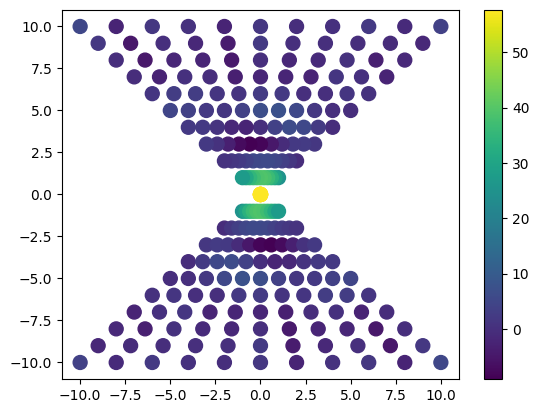

In [98]:
plt.scatter(hori_x_coords.flatten(), hori_y_coords.flatten(),
            c=true_hori_ppfft.real.flatten(), s=100)
plt.colorbar()
plt.show()

In [99]:
np.max(np.abs(true_hori_ppfft - hori_ppfft))


4.6534107757984117e-14

We also compute the values of the DTFT on a cartesian grid, to check that our new discretization makes sense.

In [100]:
cartesian_x = np.arange(-n, n+1)
cartesian_y = np.arange(-n, n+1)
xx, yy = np.meshgrid(cartesian_x, cartesian_y)


In [101]:
cartesian_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(
    np.pad(a, ((n//2, n//2 + 1), (n//2, n//2 + 1))))))


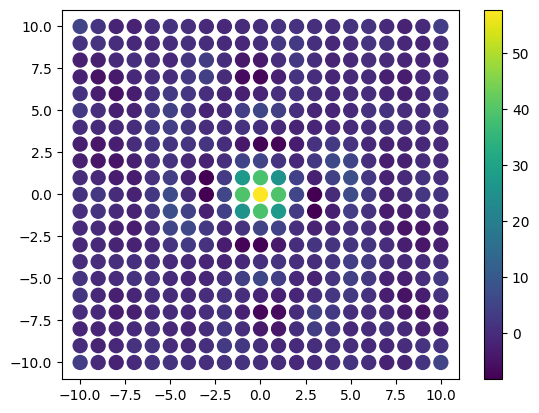

In [102]:
plt.scatter(xx.flatten(), yy.flatten(), c=cartesian_fft.real.flatten(), s=100)
plt.colorbar()
plt.show()


# Vertical lines

In [103]:
def ppfft_vertical(a: np.ndarray) -> np.ndarray:
    """
    Pseudo-Polar Fast Fourier Transform on the basically vertical lines.

    ## Parameters
    a : np.ndarray
        Input array of shape (n, n) where n is even.

    ## Returns
    y : np.ndarray
        Ouput array of shape (n+1, 2*n+1).

    ## See Also
    ppfft_horizontal : Return the PPFFT on the basically horizontal lines.
    """
    return ppfft_horizontal(a.T)


Here we define the coordinates of the vertical lines. In the paper, they are given by (when $n$ is even):
$$
\left\{ \left(k, - \frac{2l}{n}k \right) \mid l \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket, \, k \in \llbracket -n, n \rrbracket \right\}
$$

In [104]:
def vertical_lines(n: int):
    """
    Computes the positions of the basically vertical lines of the pseudo-polar grid.

    ## Parameters
    n : int
        Size of the image whose PPFFT we want to compute.

    ## Returns
    coords : np.ndarray
        Array of shape (n+1, 2*n+1, 2). coords[..., 0] gives the x coordinates.

    ## See Also
    horizontal_lines : Return the positions of the basically horizontal lines of the pseudo-polar grid.
    """
    m = 2 * n + 1
    coords = np.empty(shape=(n + 1, m, 2))

    for i_l, l in enumerate(domain(n + 1)):
        for i_k, k in enumerate(domain(m)):
            coords[i_l, i_k, 0] = k
            coords[i_l, i_k, 1] = -2 * l * k / n

    return coords


In [105]:
vert_coords = vertical_lines(10)
vert_x_coords = vert_coords[..., 0]
vert_y_coords = vert_coords[..., 1]


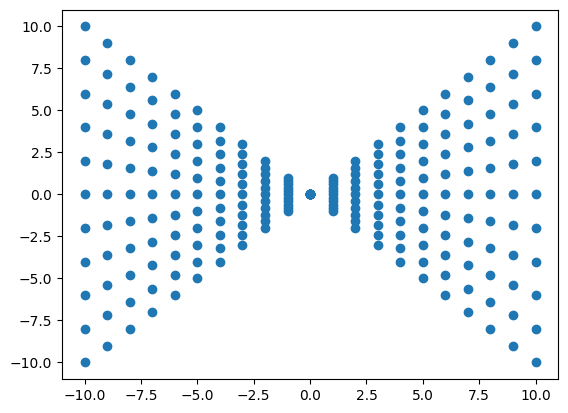

In [106]:
plt.scatter(vert_x_coords.flatten(), vert_y_coords.flatten())


In [107]:
vert_ppfft = ppfft_vertical(a)


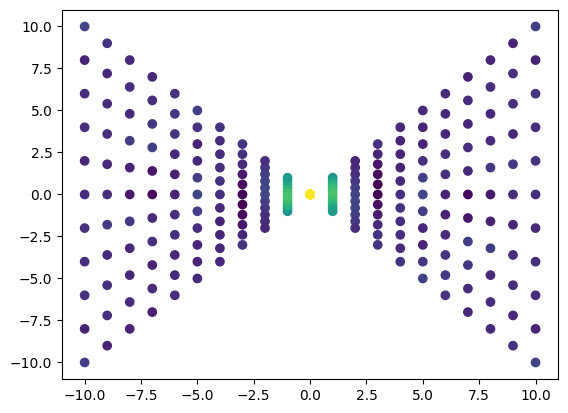

In [108]:
plt.scatter(vert_x_coords.flatten(), vert_y_coords.flatten(),
            c=vert_ppfft.real.flatten())


In [109]:
true_vert_ppfft = np.empty(shape=(n + 1, 2 * n + 1), dtype=complex)

for l in range(n + 1):
    for k in range(2 * n + 1):
        true_vert_ppfft[l, k] = slow_DTFT(
            a, vert_x_coords[l, k], vert_y_coords[l, k], 2 * n + 1)


In [110]:
np.max(np.abs(true_vert_ppfft - vert_ppfft))


3.260957681782951e-14

# Entire grid

In [111]:
x_coords = np.concatenate((hori_x_coords.flatten(), vert_x_coords.flatten()))
y_coords = np.concatenate((hori_y_coords.flatten(), vert_y_coords.flatten()))
ppfft = np.concatenate((hori_ppfft.flatten(), vert_ppfft.flatten()))


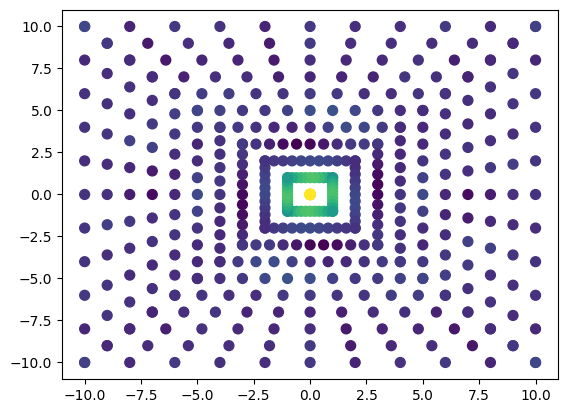

In [112]:
plt.scatter(x_coords, y_coords, c=ppfft.real, s=50)


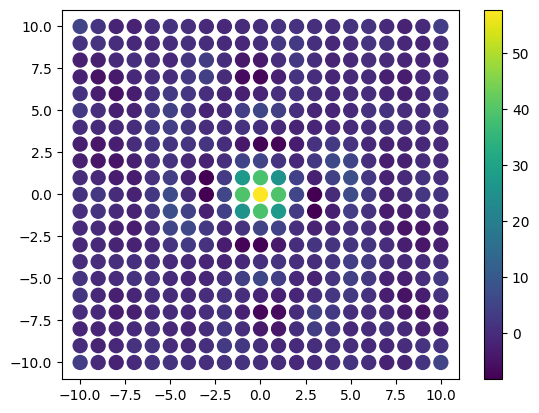

In [113]:
plt.scatter(xx.flatten(), yy.flatten(), c=cartesian_fft.real.flatten(), s=100)
plt.colorbar()
plt.show()


In [136]:
def ppfft(im):
    return ppfft_horizontal(im), ppfft_vertical(im)

# Adjoint PPFFT

In [137]:
def adjoint_ppfft_horizontal(hori_ppfft):
    n = hori_ppfft.shape[0] - 1
    m = 2 * n + 1

    hori_aux = np.empty(shape=(n, m), dtype=complex)

    for k, col in zip(domain(m), hori_ppfft.T):
        hori_aux[:, k + n] = adj_frac_fft(col, beta=-2 * k / (n * (2 * n + 1)), n=n)

    hori_aux = adj_pad(adj_new_fft(hori_aux), (n, n))

    return hori_aux


def adjoint_ppfft_vertical(vert_ppfft):
    return adjoint_ppfft_horizontal(vert_ppfft).T


def adjoint_ppfft(hori_ppfft, vert_ppfft):
    return adjoint_ppfft_horizontal(hori_ppfft) + adjoint_ppfft_vertical(vert_ppfft)

In [138]:
n = 10
a = np.random.rand(n, n)
b = np.random.rand(n + 1, 2 * n + 1)
print(np.isclose(np.vdot(ppfft_horizontal(a), b), np.vdot(a, adjoint_ppfft_horizontal(b))))

n = 11
a = np.random.rand(n, n)
b = np.random.rand(n + 1, 2 * n + 1)
print(np.isclose(np.vdot(ppfft_horizontal(a), b), np.vdot(a, adjoint_ppfft_horizontal(b))))

True
True


In [139]:
n = 10
a = np.random.rand(n, n)
b = np.random.rand(n + 1, 2 * n + 1)
print(np.isclose(np.vdot(ppfft_vertical(a), b), np.vdot(a, adjoint_ppfft_vertical(b))))

n = 11
a = np.random.rand(n, n)
b = np.random.rand(n + 1, 2 * n + 1)
print(np.isclose(np.vdot(ppfft_vertical(a), b), np.vdot(a, adjoint_ppfft_vertical(b))))

True
True


In [141]:
n = 10
im1 = np.random.rand(n, n)
im2 = np.random.rand(n + 1, 2 * n + 1)
im3 = np.random.rand(n + 1, 2 * n + 1)

h, v = ppfft(im1)

prod1 = np.vdot(h, im2) + np.vdot(v, im3)
prod2 = np.vdot(im1, adjoint_ppfft(im2, im3))
np.isclose(prod1, prod2)

True

In [142]:
n = 11
im1 = np.random.rand(n, n)
im2 = np.random.rand(n + 1, 2 * n + 1)
im3 = np.random.rand(n + 1, 2 * n + 1)

h, v = ppfft(im1)

prod1 = np.vdot(h, im2) + np.vdot(v, im3)
prod2 = np.vdot(im1, adjoint_ppfft(im2, im3))
np.isclose(prod1, prod2)

True